In [3]:
import torch

from utils import load_model
from models.get_model import get_model
from dataset import UltrasonicDataset
from torchvision.transforms import v2

import json
from matplotlib import pyplot as plt
import cv2
import numpy as np


In [1]:
run_name = "2023-11-16_15-12-53"

run_path = f"runs/{run_name}/"

In [4]:
train_summary = json.load(open(run_path + "train_summary.json"))

model_name = train_summary["config"]["MODEL"]
IMAGE_SIZE = train_summary["config"]["IMAGE_SIZE"]

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [5]:
model = get_model(model_name, IMAGE_SIZE)
model = model.to(DEVICE)

model = load_model(model, run_path + "best_model.pth")

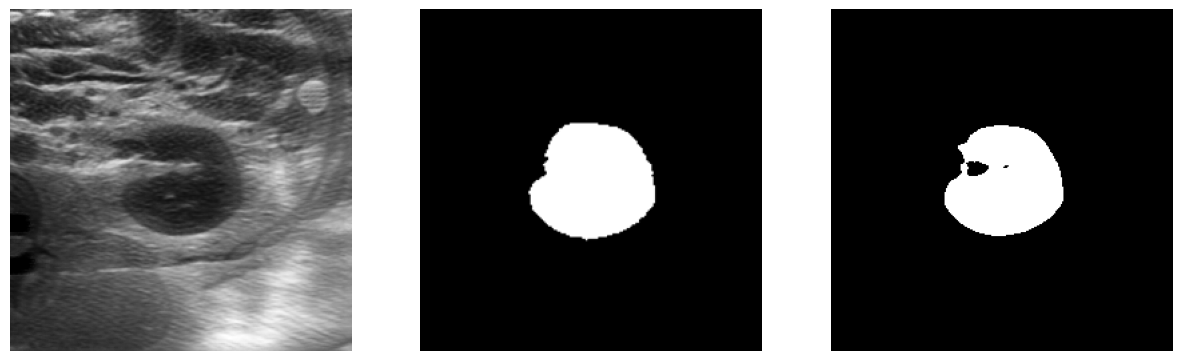

Dice score: 0.9538593888282776


/tmp/ipykernel_58476/3884710612.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(mask / 255).unsqueeze(0).unsqueeze(0).float().to(DEVICE)


In [20]:
transforms_test = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32),
    v2.Resize((IMAGE_SIZE, IMAGE_SIZE), antialias=True),
])

dataset_test = UltrasonicDataset("datasets/CT2US/test", transforms_test)

index = np.random.randint(len(dataset_test))

img, mask = dataset_test[index]

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(img[0], cmap="gray")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(mask[0], cmap="gray")
plt.axis("off")


with torch.no_grad():
    model.eval()
    img_tensor = img.unsqueeze(0).to(DEVICE)
    pred = model(img_tensor)
    if model._get_name() == "LRASPP":
        pred = pred["out"]

    if model._get_name() == "MobileViTV2ForSemanticSegmentation" or\
        model._get_name() == "SegformerForSemanticSegmentation":
        pred = pred[0]
        pred = torch.nn.functional.interpolate(pred, size=(256, 256), mode='bilinear', align_corners=False)
    # pred = torch.sigmoid(pred)
    pred = pred


pred_mask = pred.squeeze(0)[1].cpu().numpy()
pred_mask = pred_mask > 0.5

plt.subplot(1, 3, 3)
plt.imshow(pred_mask, cmap="gray")
plt.axis("off")
plt.show()


target = torch.tensor(mask / 255).unsqueeze(0).unsqueeze(0).float().to(DEVICE)

from monai.metrics import DiceMetric
from monai.transforms import Compose, AsDiscrete
from monai.data import decollate_batch


post_label = Compose([AsDiscrete(to_onehot=2)])
post_pred = Compose([AsDiscrete(argmax=True, to_onehot=2)])
dice_acc = DiceMetric(include_background=True, get_not_nans=True)


val_labels_list = decollate_batch(target)
val_labels_convert = [post_label(val_label_tensor) for val_label_tensor in val_labels_list]

val_outputs_list = decollate_batch(pred)
val_output_convert = [post_pred(val_pred_tensor) for val_pred_tensor in val_outputs_list]

dice_acc(y_pred=val_output_convert, y=val_labels_convert)

dice = dice_acc.aggregate()[0].cpu().numpy()[0]

print(f"Dice score: {dice}")

In [1]:
import torch
from transformers import MobileViTV2ForSemanticSegmentation, MobileViTV2Config
import torchsummary

configuration = MobileViTV2Config(num_channels=1, image_size=256, num_classes=2, return_dict=False, output_stride=8)
model = MobileViTV2ForSemanticSegmentation(configuration)
 
# model

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(DEVICE)

img = torch.randn(2, 1, 256, 256).to(DEVICE)

out = model(img)[0]

#upsample the results to the original image size
out = torch.nn.functional.interpolate(out, size=(256, 256), mode='bilinear', align_corners=False)

print(out.shape)

torch.Size([2, 2, 256, 256])


In [43]:
print(model._get_name())

MobileViTV2ForSemanticSegmentation


In [8]:
from transformers import  SegformerForSemanticSegmentation, SegformerConfig


configuration = SegformerConfig(num_channels=1, image_size=256, num_classes=2, return_dict=False)

model = SegformerForSemanticSegmentation(configuration)

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(DEVICE)

img = torch.randn(2, 1, 256, 256).to(DEVICE)

out = model(img)[0]

out = torch.nn.functional.interpolate(out, size=(256, 256), mode='bilinear', align_corners=False)

print(out.shape)

print(model._get_name())

torch.Size([2, 2, 256, 256])
SegformerForSemanticSegmentation
